## Using Eleanor API to Identify resolve our Saturated Targets

The aim is to read in TIC ID's of the saturated targets (which are also likely 2-min target candidates) and download + compute the contents of `single_analysis_xrp.py` onto it, as the lightcurves from the Bucket use Eleanor's default apertures. This is fine for the most part, but as we have found out that Beta Pic's exocomets cannot be seen with these default apertures, we use an arbitrarily large aperture to expand the search instead.

In [1]:
import eleanor
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
print(eleanor.__path__)

['/home/astro/phrdhx/.local/lib/python3.7/site-packages/eleanor']


Standard aperture selected when bringing in lightcurve:

## Eleanor lightcurves with default apertures

In [3]:
star = eleanor.Source(tic=270577175,sector=6) # beta pic
star_data = eleanor.TargetData(star, height=13, width=13, bkg_size=31, do_psf=True, do_pca=True)

INFO: Found cached file ./mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0006-3-3-cal-1686-0592_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0006-3-3-cal-1686-0592_tess_v2_bkg.fits with expected size 61162560. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0006-3-3-cal-1686-0592_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0006-3-3-cal-1686-0592_tess_v2_pc.fits with expected size 122411520. [astroquery.query]
INFO: Found cached file ./mastDownload/HLSP/hlsp_eleanor_tess_ffi_postcard-s0006-3-3-cal-1686-0592_tess_v2_pc/hlsp_eleanor_tess_ffi_postcard-s0006-3-3_tess_v2_pm.txt with expected size 185294. [astroquery.query]




100%|██████████| 993/993 [00:14<00:00, 70.21it/s] 


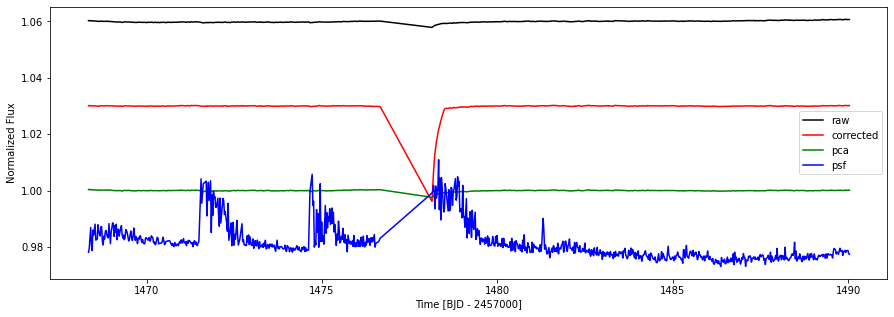

In [4]:
q = star_data.quality == 0
plt.figure(figsize=(15,5))


plt.plot(star_data.time[q], star_data.raw_flux[q]/np.nanmedian(star_data.raw_flux[q])+0.06, 'k',label='raw')
plt.plot(star_data.time[q], star_data.corr_flux[q]/np.nanmedian(star_data.corr_flux[q]) + 0.03, 'r',label='corrected')
plt.plot(star_data.time[q], star_data.pca_flux[q]/np.nanmedian(star_data.pca_flux[q]), 'g',label='pca')
plt.plot(star_data.time[q], star_data.psf_flux[q]/np.nanmedian(star_data.psf_flux[q]) - 0.02, 'b',label='psf')
plt.ylabel('Normalized Flux')
plt.xlabel('Time [BJD - 2457000]')
plt.legend();

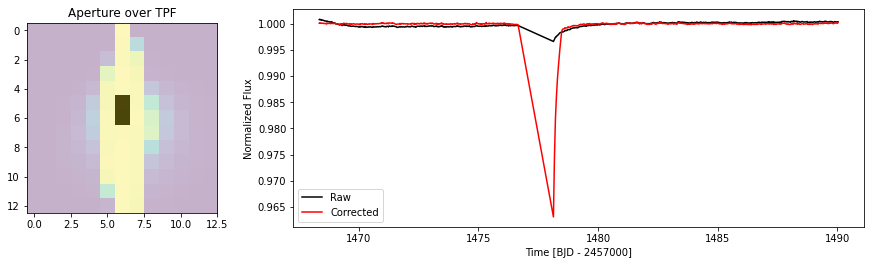

In [5]:
fig, (ax, ax1) = plt.subplots(ncols=2, figsize=(15,4), gridspec_kw={'width_ratios':[1,3]})
ax.imshow(star_data.tpf[0])
ax.imshow(star_data.all_apertures[0], cmap='Greys', alpha=0.7)
ax.set_title('Aperture over TPF')

ax1.plot(star_data.time[q], star_data.all_raw_flux[0][q]/np.nanmedian(star_data.all_raw_flux[0][q]), 'k', label='Raw')
ax1.plot(star_data.time[q], star_data.all_corr_flux[0][q]/np.nanmedian(star_data.all_corr_flux[0][q]), 'r', label='Corrected')
ax1.set_xlabel('Time [BJD - 2457000]')
ax1.set_ylabel('Normalized Flux')
ax1.legend();

### The chosen `Eleanor` aperture

In [ ]:
vis = eleanor.Visualize(star_data)
vis.aperture_contour()

## Custom Aperture

In [ ]:
eleanor.TargetData.custom_aperture(star_data, shape='rectangle', h=13, w=3)
eleanor.TargetData.get_lightcurve(star_data)

fig, (ax2, ax3) = plt.subplots(ncols=2, figsize=(15,4), gridspec_kw={'width_ratios':[1,3]})
ax2.imshow(star_data.tpf[0])
ax2.imshow(star_data.aperture, cmap='Greys', alpha=0.5)
ax2.set_title('Aperture over TPF')
#plt.imshow(data.aperture)

ax3.plot(star_data.time[q], star_data.raw_flux[q]/np.nanmedian(star_data.raw_flux[q]), 'black', label='Raw')
ax3.plot(star_data.time[q], star_data.corr_flux[q]/np.nanmedian(star_data.corr_flux[q]), 'magenta', label='Corrected')
ax3.plot(star_data.time[q], star_data.pca_flux[q]/np.nanmedian(star_data.pca_flux[q]) - 0.0009, 'r', label='PCA Corrected')
ax3.legend(loc='upper left')         
#ax2.set_ylim([0.997,1.001])
#ax2.set_xlim([1485,1487])
ax3.set_xlabel('Time [BJD - 2457000]')
ax3.set_ylabel('Normalized Flux')


In [ ]:
eleanor.TargetData.custom_aperture(star_data, shape='rectangle', h=14, w=4.5)
plt.plot(star_data.time[q], star_data.corr_flux[q]/np.nanmedian(star_data.corr_flux[q]), 'magenta', label='Corrected')

notes:

```star = eleanor.Source(tic=bucket.TIC_ID[i],sector=bucket.sector[i])
 data = eleanor.TargetData(star, height=13, width=13, bkg_size=31, do_psf=True, do_pca=True)```
 
 could be a possible idea of how to download raw `eleanor` files and operate saturated star analysis on that.

In [ ]:
cd ..

## Applying MAD cuts

In [ ]:
from analysis_tools_cython import *
import data
import loaders
from astropy.stats import sigma_clip,sigma_clipped_stats
from astropy.table import Table
from astropy.time import Time

In [ ]:
bad_times = data.load_bad_times()
bad_times = bad_times - 2457000
mad_df = data.load_mad()

In [ ]:
sec = 6
cam = 1
mad_arr = mad_df.loc[:len(star_data.time[q])-1, f"{sec}-{cam}"]

In [ ]:
clip = 3
sig_test = sigma_clip(mad_arr,sigma=clip,masked=False)
med_sig_clip = np.nanmedian(sig_test)
rms_sig_clip = np.nanstd(sig_test)


In [ ]:
fig,ax = plt.subplots(figsize=(19,8))
ax.scatter(range(0,len(star_data.time[q])), mad_arr, s=2)
ax.axhline(np.nanmedian(mad_arr), c='r',label='median')
ax.axhline(np.nanmedian(mad_arr)+10*np.std(mad_arr[900:950]),c='blue',label='visualised MAD') # 10 sigma threshold
ax.axhline(med_sig_clip + clip*rms_sig_clip, c='orange',label='experiment MAD')
ax.set_xlabel('Cadence Number')
ax.set_ylabel('Mean Absolute Deviation (MAD)')
ax.set_title(f'Cadence at {sec}-{cam}')
ax.legend()
plt.show()

In [ ]:
mad_cut = mad_arr.values<(np.nanmedian(mad_arr)+10*np.std(mad_arr[900:950])) # removes any values above threshold
mad_cut2 = mad_arr.values<(med_sig_clip + clip*(rms_sig_clip))

In [ ]:
mask = np.ones_like(star_data.time[q], dtype=bool)
for i in bad_times:
    newchunk = (star_data.time[q]<i[0])|(star_data.time[q]>i[1])
    mask = mask & newchunk

In [ ]:
fig,ax = plt.subplots(2,figsize=(25,8))

#ax[0].plot(star_data.time[q],star_data.corr_flux[q]/np.nanmedian(star_data.corr_flux[q]),label='original lightcurve',color='black')
ax[0].plot(star_data.time[q & mask & mad_cut2 ] ,star_data.corr_flux[q & mask & mad_cut2]/np.nanmedian(star_data.corr_flux[q & mask & mad_cut2] ),label='MAD applied lightcurve',color='red')


In [ ]:
plt.plot(star_data.time[star_data.quality==0],star_data.corr_flux[star_data.quality==0])
plt.plot((star_data.time[star_data.quality==0] & mask),(star_data.corr_flux[star_data.quality==0] & mask))

In [ ]:
type(mask)

In [ ]:
type(mad_cut)

In [ ]:
type(star_data.time[q])

In [ ]:
star_data.time[q] and mask